# Purpose of tis Notebook

This notebook is used for training the test models. It inputs numpy arrays that are extracted by extract_arrays.ipynb. tHe paths to these should be entered in the FEATURES_PATH and LABELS_PATH variables.

The notebook trains the models and print the evaluate results. It also saves the models for reuse. 




In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

SEED = 42

In [2]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [3]:
FEATURES_PATH = "data/my_20_sec_features-AWS_trial_NO_GUI_30k-2023_03_25__03_36_34.npy"
LABELS_PATH = "/Users/michaelkearney/Documents/Uni/UNB_Datasets/data/my_20_sec_labels-AWS_trial_NO_GUI_30k-2023_03_25__03_36_34.npy"
SITES_PATH = "VPN_client_scripts/urls/top_100.csv"
MODEL_NAME = "30K-retrain"


MODEL_PATH = "models/convlstm_large_model_Datetime_2022_10_20__22_26_06__loss_0.533180296421051_acc_0.9062302112579346.h5"
SCALER_MAX = 1294.0

In [4]:
model = tf.keras.models.load_model(MODEL_PATH)

2023-03-25 14:40:47.345520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
sites_df = pd.read_csv(SITES_PATH, names=["ranking", "site"])
sites = list(sites_df.site)
len(sites)

100

In [6]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(11497, 200, 150, 2)

In [7]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(11497,)

In [8]:
sites_df = pd.read_csv(SITES_PATH, names=["ranking", "site"])
sites = list(sites_df.site)
sites[:10]

['google.com',
 'youtube.com',
 'facebook.com',
 'baidu.com',
 'instagram.com',
 'yahoo.com',
 'qq.com',
 'wikipedia.org',
 'bing.com',
 'bilibili.com']

In [9]:
for i, label in enumerate(labels):
  if label not in sites:
    labels[i] = "Other"

In [10]:
count = 0
for label in np.unique(labels, axis=0):
  print(label)
  count += 1

print(f"Num nuique = {count}")

163.com
1688.com
360.cn
3dmgame.com
52pojie.cn
Other
adobe.com
aliexpress.com
amazon.com
amazonaws.com
apple.com
baidu.com
bilibili.com
bing.com
booking.com
canva.com
chaturbate.com
chsi.com.cn
cnblogs.com
csdn.net
deepl.com
discord.com
disneyplus.com
douban.com
douyu.com
duckduckgo.com
dzen.ru
ebay.com
etsy.com
facebook.com
fandom.com
flipkart.com
freepik.com
github.com
google.com
hao123.com
hbomax.com
huya.com
ilovepdf.com
imdb.com
indeed.com
instagram.com
instructure.com
iqiyi.com
jd.com
linkedin.com
live.com
mail.ru
mediafire.com
microsoft.com
msn.com
myshopify.com
netflix.com
office.com
ok.ru
onlyfans.com
paypal.com
pinterest.com
pornhub.com
primevideo.com
qq.com
quora.com
rakuten.co.jp
reddit.com
roblox.com
sina.com.cn
so.com
sogou.com
sohu.com
soso.com
spankbang.com
spotify.com
stackoverflow.com
stripchat.com
t.me
taobao.com
telegram.org
tiktok.com
tmall.com
tradingview.com
twitch.tv
twitter.com
udemy.com
vk.com
weibo.com
whatsapp.com
wikipedia.org
wordpress.com
xhamster.com
xnx

In [11]:
label_binariser = LabelBinarizer()
label_binariser.classes_ = np.load('encoders/classes.npy')
# label_binariser.fit(pd.DataFrame(sites))
labels_encoded = label_binariser.transform(labels)
del(labels)
labels_encoded.shape

(11497, 100)

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_encoded,
    test_size=0.25,
    shuffle=True,
    random_state=SEED
)

del(features)

In [13]:


features_train = features_train/SCALER_MAX
features_test = features_test/SCALER_MAX


In [14]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=1)


In [16]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')

    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')

    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")

    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])

In [17]:
y_true = np.argmax(labels_test, axis=1)
unique_y = np.unique(y_true)

In [18]:
def plot_results(model):
    fig, ax = plt.subplots(figsize=(30, 30))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))

SyntaxError: invalid syntax (2849446358.py, line 12)

In [ ]:
convlstm_history = model.fit(x=features_train, y=labels_train, epochs=50, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/5
4/7 [================>.............] - ETA: 4:27 - loss: 9.2321 - accuracy: 0.4602 

Final training accuracy: 0.9481559991836548
Final validation accuracy: 0.8852517008781433


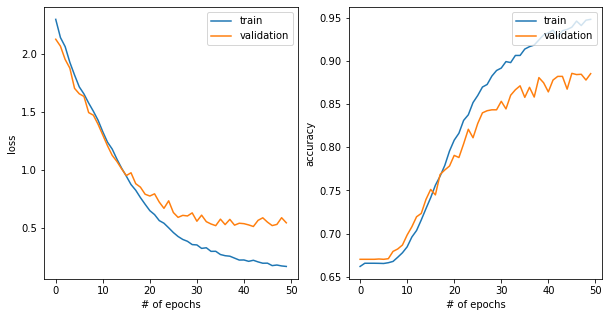

In [ ]:
plot_history(convlstm_history)

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
loss, acc = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.datetime.now()
current_datetime_string = dt.datetime.strftime(current_datetime, date_time_format)
model_file_name =f"convlstm_{MODEL_NAME}_model_Datetime_{current_datetime_string}__loss_{loss}_acc_{acc}.h5"
convlstm_model.save(os.path.join("models", model_file_name))

148/148 [==============================] - 50s 335ms/step - loss: 0.5332 - accuracy: 0.9062


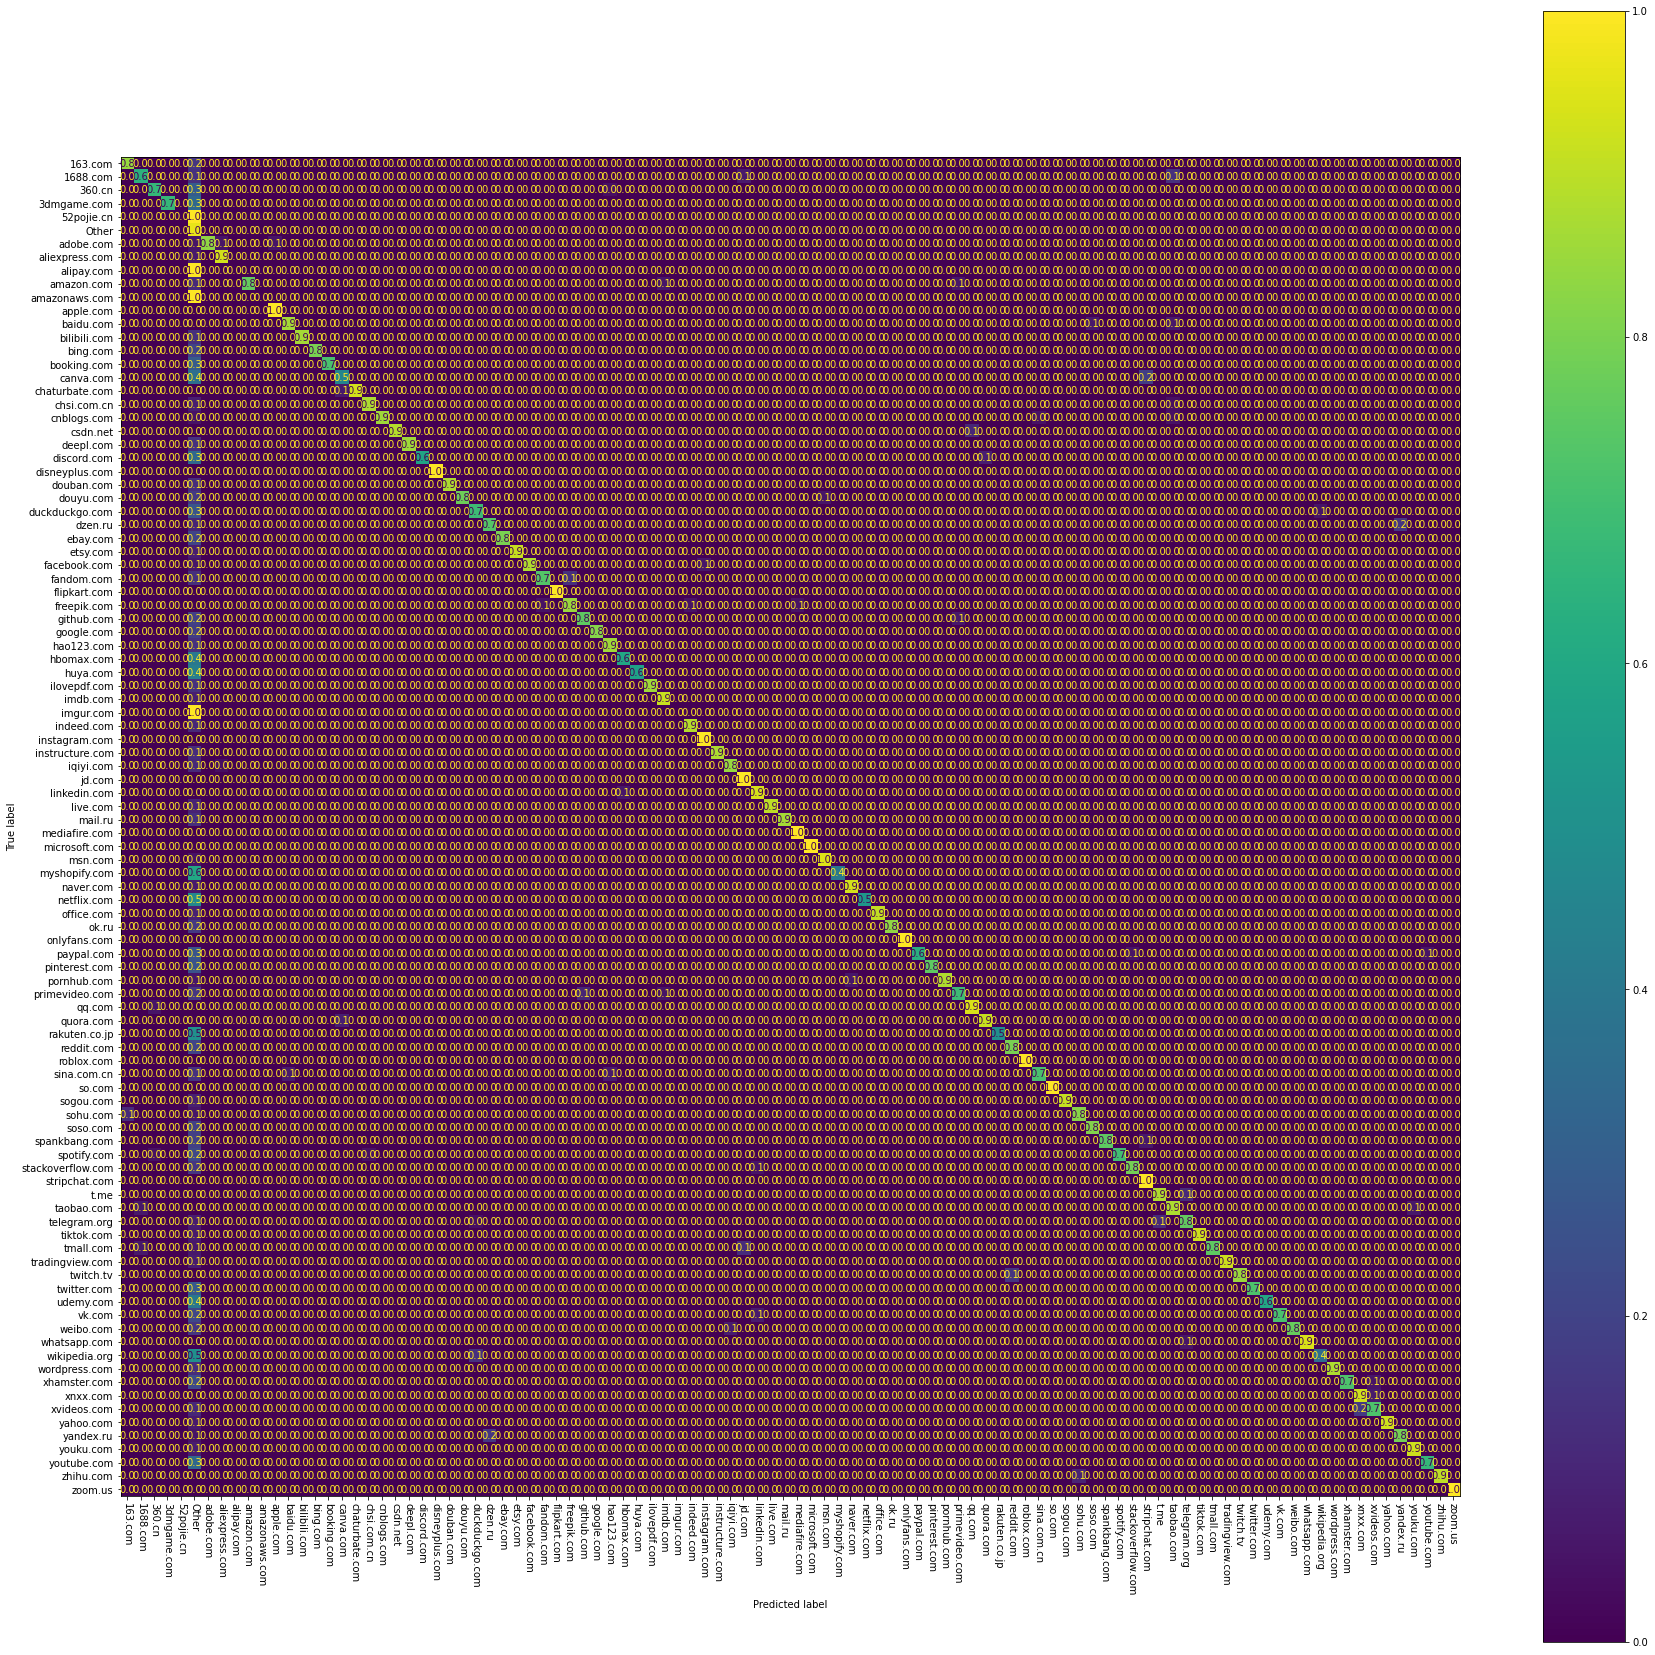

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.82      0.64      0.72        14
           2       0.76      0.67      0.71        24
           3       0.86      0.67      0.75         9
           4       0.00      0.00      0.00        16
           5       0.92      0.97      0.94      3135
           6       0.79      0.83      0.81        18
           7       0.82      0.93      0.87        15
           8       0.00      0.00      0.00        22
           9       1.00      0.76      0.87        17
          10       0.00      0.00      0.00        15
          11       0.81      1.00      0.90        13
          12       0.93      0.87      0.90        15
          13       1.00      0.87      0.93        15
          14       0.89      0.80      0.84        10
          15       0.83      0.71      0.77        14
          16       0.62      0.45      0.53        11
          17       0.74    

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [ ]:
plot_results(convlstm_model)

In [ ]:
[[x, label_binariser.classes_[x]] for x in range(unique_y.min(), len(unique_y))]

[[0, '163.com'],
 [1, '1688.com'],
 [2, '360.cn'],
 [3, '3dmgame.com'],
 [4, '52pojie.cn'],
 [5, 'Other'],
 [6, 'adobe.com'],
 [7, 'aliexpress.com'],
 [8, 'alipay.com'],
 [9, 'amazon.com'],
 [10, 'amazonaws.com'],
 [11, 'apple.com'],
 [12, 'baidu.com'],
 [13, 'bilibili.com'],
 [14, 'bing.com'],
 [15, 'booking.com'],
 [16, 'canva.com'],
 [17, 'chaturbate.com'],
 [18, 'chsi.com.cn'],
 [19, 'cnblogs.com'],
 [20, 'csdn.net'],
 [21, 'deepl.com'],
 [22, 'discord.com'],
 [23, 'disneyplus.com'],
 [24, 'douban.com'],
 [25, 'douyu.com'],
 [26, 'duckduckgo.com'],
 [27, 'dzen.ru'],
 [28, 'ebay.com'],
 [29, 'etsy.com'],
 [30, 'facebook.com'],
 [31, 'fandom.com'],
 [32, 'flipkart.com'],
 [33, 'freepik.com'],
 [34, 'github.com'],
 [35, 'google.com'],
 [36, 'hao123.com'],
 [37, 'hbomax.com'],
 [38, 'huya.com'],
 [39, 'ilovepdf.com'],
 [40, 'imdb.com'],
 [41, 'imgur.com'],
 [42, 'indeed.com'],
 [43, 'instagram.com'],
 [44, 'instructure.com'],
 [45, 'iqiyi.com'],
 [46, 'jd.com'],
 [47, 'linkedin.com'],
